### Capstone - StarCraft II<br>by Mycchaka Kleinbort

<right><img src="./Images/AI_timeline.png" style=" margin: 5px; width: 1080px"></right>

It is perhaps inevitable that any game played by humans will eventualy become the subject of ongoing A.I. research. The framework of games - rules and objectives - is inherently suited to systematic study, and their ever increasing complexity has motivated a seemingly endless stream of new tools and insights.

In November of 2016 Google DeepMind - in partnership with Blizzard entertainment - anounced their intention to make Starcraft 2 the focus of further A.I. research. In this project we seek to compile and explore the currently available data, to extract and infer features that can qualify a player's performance, and to validate these features by building several predictive models.

[](#objectives)
## Objectives

>The game lasted for 73 moves but eventually Deep Blue's operator had to resign the game for the computer in a position where both players had a bishop but Kasparov had three pawns to Deep Blue's one.
<br>
><div style="color:gray ; text-align: left">_Kasparov vs Deep Blue - Game 2, 1996_</div>

At low skill levels players often go through the motions of torching every house and eliminating every larva till the game engine grants them victory. However, much like in chess, experienced players know when it's over and conceed the match. 

This ability to distinguish between a dificult situation and a hopless one is admirable and as of yet utterly beyond thecapabilities of the game's AI. We hope that through exploring this aspect of the game, several interesting metrics for a player's performance will come to light.

### Principal objective

Our main goal is to build a predictive model that can predict a player's eventual surrender based on the game's current state. Formaly this will be a classification model that will take as input the game state and predict for each player weather they will eventually surrender or win the game.

Intuition tells us that this model will be capable predicting the winner with increasing certainty and accuracy as the game progresses. Hopefully, by analyzing the model's predictions will allow us to percieve:

   - games where a player's advantage is becoming ever more entrenched.
   - games where the player manages to overcome a dificult situation.
   - games where the odds of each player change dramatically due to one battle or choice. 
   
### Preliminar objective

Our task above has a very clear 'simplest case': 

    To predict who surrendered at the moment the game ended.

Our first efforts are directed towards attaining a reasonably accurate model capable of predicting who was the winner given the final game state.

For example 

In [154]:
from IPython.display import HTML
# Youtube: A Terran vs Zerg game
HTML("""<iframe width="854" height="480" 
     src="https://www.youtube.com/embed/Yjj7QFV62p0?rel=0&amp;controls=1&amp;showinfo=0" 
     frameborder="0" allowfullscreen></iframe>""")

### Scope

We restrict our attention exclusively to:
   - 1v1 games
   - played under the latest major update to the game (LotV)
   - in maps that have been part of the ladder rotation
   - with the default competitive ruleset.

### Technical challenges resolved in other notebooks

##### Sourcing the data:
With approximately 100,000 StarCraft II games played daily, replay files are a dime a dozen. We sourced several hundred replay files through web scraping.

The proces was relatively straigh forwad, but details can be found in the sister notebook:

> Sourcing Data.ipynb

##### The replay file format:
A significan issue we faced was dealing with the unstructured data of replay files. 

It is not particularly important for the reader to be familiar whith Blizzard's proprietary format, but it is worth noting that:

   - The replay files are a hexadecimal representation of human actions during the game. Due to the deterministic nature of StarCraft II this is all that is required for the game engine to produce a factsimilie of the match.
   - We made use of sc2reader - an open source python library - to parse a replay files into a python object.
   - We munged the information of the parsed files into elementary python objects improving loading times by 99.8%, ram consumption by 99%, and disk space by 50%. Details of our work in this area can be found in the sister notebook:

> Converting replays to dictionaries.ipynb
    

## SECTION 1: Data Retrieval

We start with explorig the dictioary represetatio of a replay file. We load the previously processed 422 games of the IEM Season XI - World Championship that took place in early 2017.

In [6]:
import pickle
with open('./../../../sc2games/PickledGames/iem_replays.p','rb') as corpus:
    iem_games = pickle.load(corpus)
    
example_game = iem_games[0]

In [7]:
example_game.keys()

dict_keys(['context', 'objects', 'player_stats', 'unit_positions', 'upgrades', 'object_keys', 'player_stat_keys'])

A pre-processed replay contains five sets of information: the objects, player stats, upgrade data, possition data and context. Repsectively, these ecode:

##### Objects
All units, buildigns, mieral deposits or other player-intractable objects that occured throughout the match. These are idexed by their unique id (internal to the game they were part of) and contain iformation shuch as their time of creation, their time of death, what player controlled and other features that can't be looked up in a referece table.

##### Player stats
The game keeps track of several player statistics at 10 second itervals throught the match. Several of these metrics for player performace may be deduced from the object data (such as total army value), but others (such as resource collection rate or upgrades in progress) are only available here. The player stats section of the pre-processed replay file contains the iformation that can't be deduced.

##### Upgrade data
The origianal replay files contained a log of evets, some of which indicated that a player had compleated an upgrade. Here we stored the upgrade obtained, the player who obtaied it, and the time at which this happened.

##### Possition data
The origial replay file has a somwhat eclectic behaviour with regards to unit possition tracking. In addition to the locations at the end of the game (or where the unit died) the game also logs - every 15 secods - the location of units that took damage within the last 15 seconds. Accurate unit tracking is a task performed by the game engine.

Due to data quality issues, we will not include this data in our initial modeling.

##### Context
This is the metadata obtained through sc2reader. It includes the date of the game, the map, the player names, the version of the game, the ruleset used, the time zone, location of the game server that hosted the match, etc. Our main use of this iformation is to verify that a game falls within the scope of this project (1v1 games played with the stadard ruleset, on standard maps, since the most recent major change to the game).

We convert this data to dataframes an perform some basic data cleaning

### Units

In [8]:
import pandas as pd

# Parsing unit data to dataframe
def parse_unit_data(replay_dict):
        df_units = pd.DataFrame(data = replay_dict['objects']).T
        df_units.columns = columns=replay_dict['object_keys']
        return df_units

In [9]:
example_units = parse_unit_data(example_game)
example_units.sample(5, random_state=2)

,died_at,finished_at,hallucinated,id,killed_by,killed_units,killing_player,killing_unit,location,name,owner,race,started_at
82575362,6572,6540,False,82575362,2,[],2,68419585,"(66, 157)",KD8Charge,2,Neutral,6540
141033474,17509,15976,False,141033474,1,[133693444],1,143654917,"(88, 144)",Marine,2,Terran,15976
22806530,13834,12370,False,22806530,2,[126877697],2,125829122,"(94, 150)",Marine,1,Terran,12370
67633155,4225,4193,False,67633155,2,[],2,68419585,"(70, 157)",KD8Charge,2,Neutral,4193
3407874,17110,14558,False,3407874,1,[],1,79953930,"(67, 152)",Marine,2,Terran,14558


> Note that the unit of time is 'frames', the number if 16th of a second since the game started.

We will make the unit names lower case an unzip the location touples.

In [10]:
def clean_unit_data(df_units):
    df_units['x'], df_units['y'] = zip(*df_units['location'].values)
    df_units = df_units.drop(['location'], axis=1)
    df_units['name'] = df_units['name'].apply(lambda x:x.lower())
    return df_units

In [11]:
example_clean_units = clean_unit_data(example_units)
example_clean_units.sample(5, random_state=2)

,died_at,finished_at,hallucinated,id,killed_by,killed_units,killing_player,killing_unit,name,owner,race,started_at,x,y
82575362,6572,6540,False,82575362,2,[],2,68419585,kd8charge,2,Neutral,6540,66,157
141033474,17509,15976,False,141033474,1,[133693444],1,143654917,marine,2,Terran,15976,88,144
22806530,13834,12370,False,22806530,2,[126877697],2,125829122,marine,1,Terran,12370,94,150
67633155,4225,4193,False,67633155,2,[],2,68419585,kd8charge,2,Neutral,4193,70,157
3407874,17110,14558,False,3407874,1,[],1,79953930,marine,2,Terran,14558,67,152


### Player Stats

In [12]:
# Parsing player stats data into dataframe
def parse_stats_data(replay_dict):
    df_stats = pd.DataFrame(data = replay_dict['player_stats'])
    df_stats.columns = columns=replay_dict['player_stat_keys']
    return df_stats

In [13]:
example_stats = parse_stats_data(example_game)

# We display the traspose for readibility
example_stats.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
frame,17280,160,4800,11360,160,4800,11360,2400,12800,12800,15520,2400,7680,15520,7680
minerals_collection_rate,2351,335,1399,3219,251,1231,1987,867,2687,1875,1987,839,1791,2099,1623
minerals_current,388,40,105,50,30,240,68,75,735,188,143,50,165,463,68
minerals_used_in_progress_army,1000,0,250,400,0,100,550,50,600,600,950,50,500,850,200
minerals_used_in_progress_economy,0,50,200,0,50,100,400,550,100,150,0,550,500,0,100
minerals_used_in_progress_technology,0,0,0,575,0,0,0,0,400,275,0,0,300,150,425
pid,1,1,1,1,2,2,2,1,1,2,1,2,1,2,2
vespene_collection_rate,985,0,313,1007,0,313,649,179,940,627,1007,156,649,627,358
vespene_current,589,0,120,68,0,195,528,98,112,928,409,98,196,994,194
vespene_used_in_progress_army,275,0,100,325,0,0,325,50,325,200,250,50,275,275,125


### Upgrades

In [14]:
# Parsing unpgrade data to dataframe
def parse_upgrade_data(replay_dict):
    df_upgrades = pd.DataFrame(replay_dict['upgrades'])
    return df_upgrades

In [15]:
example_upgrades = parse_upgrade_data(example_game)
example_upgrades.sample(5, random_state=2)

,frame,pid,second,upgrade_type_name
1,10277,2,642,ShieldWall
0,2317,2,144,SprayTerran
14,0,1,0,SprayTerran
9,14796,1,924,TerranInfantryWeaponsLevel2
19,16508,2,1031,TerranInfantryArmorsLevel2


This revealed a curios eccenticity of the game - cosmetic decorations, dance emotes and other superfluos information is logged as upgrades. We drop that information.

In [16]:
def clean_upgrade_data(df_upgrades):
    return df_upgrades[['SprayTerran' not in x and 'Reward' not in x for x in df_upgrades['upgrade_type_name']]]

In [17]:
example_upgrades_clean = clean_upgrade_data(example_upgrades)
example_upgrades_clean.sample(5, random_state=2)

,frame,pid,second,upgrade_type_name
22,10479,2,654,TerranInfantryWeaponsLevel1
11,14798,1,924,TerranInfantryArmorsLevel2
13,16180,2,1011,TerranVehicleWeaponsLevel1
1,10277,2,642,ShieldWall
19,16508,2,1031,TerranInfantryArmorsLevel2


## Context

Lets take a look at the metadata associated to our example game.

In [18]:
pd.Series(example_game['context'])

build                                                         49957
category                                                    Private
date                                            2017-03-04 11:33:31
file_time                                                      None
filehash          360f14af4958e8b31ffe210e59696cfe2cbc10e1d1f463...
filename          ./../../../sc2games/IEM XI - World Championshi...
frames                                                        17624
game_fps                                                         16
game_length                                                     786
is_ladder                                                     False
is_private                                                     True
map_name                                    Cactus Valley LE (Void)
observers         [{'name': 'CasterOne', 'pid': 3, 'messages': [...
players           [{'avg_apm': None, 'color': {'r': 180, 'g': 20...
real_length                                     

Much of this information will be used for checking the data quality of the replay file, and that if falls within the scope of our project. Of note is the terrible labeling of the game type by sc2reader. We've encountered games with 

    type = '1v1'
    real_type = 1
    len(players) = 6
    
We consider a game to be a true '1v1' if the list of players has a legth of exacly two.

The most importat part of the context information is the outcome of the game. This can be retrieved by looking at the player data.

In [19]:
# player 1
example_game['context']['players'][0]

{'avg_apm': None,
 'color': {'a': 255, 'b': 30, 'g': 20, 'name': 'Red', 'r': 180},
 'handicap': 100,
 'messages': [],
 'name': 'INnoVation',
 'pick_race': 'Terran',
 'pid': 1,
 'play_race': 'Terran',
 'result': 'Win',
 'type': None,
 'uid': 4,
 'url': 'http://xx.battle.net/sc2/en/profile/523/1/INnoVation/'}

In [118]:
# Parse the game metadata for the outcome for players 1 and 2
def parse_outcome_data(replay_dict):
    outcome = {player['result']:player['pid'] for player in replay_dict['context']['players']}
    return outcome

In [119]:
parse_outcome_data(example_game)

{'Loss': 2, 'Win': 1}

We can combine these preliminary data cleaning steps into a dictionary

In [123]:
def preliminary_procecing(replay_dict):
    dict_of_dataframes = {'units': clean_unit_data(parse_unit_data(replay_dict)),
                          'stats': parse_stats_data(replay_dict),
                          'upgrades': clean_upgrade_data(parse_upgrade_data(replay_dict)),
                          'context': replay_dict['context'],
                          'outcome':parse_outcome_data(replay_dict)}
    return dict_of_dataframes

In [36]:
example_parsed_game = preliminary_procecing(example_game)

## Section 2: Munging the data to a 1-d array.
These tables all describe a single game, but our intention is to analyse a corpus of games. To this end, the state of a single game needs to be represented as a 1-d numeric array. In this section we represent the final state of the game as a pandas series.

### Player stats data
Converting player stats data to a series is straight forwards. We simply need to find the last update to each player's stats, alter the feature names to encode the player they refer to, and concatenate this information for both players.

In [76]:
def get_stats_end(dict_of_dataframes):
    """returns a series with the stats 
    for each player at the end of the game"""
    df = dict_of_dataframes['stats'].sort_values(by='frame').tail(3)
    
    p1 = df[df['pid']==1].tail(1).to_dict()
    p2 = df[df['pid']==2].tail(1).to_dict()

    # We use the prefix S to specify that a specific feature is stats data.
    p1 = {'1'+'S_'+key:list(p1[key].values())[0] for key in p1.keys()}
    p2 = {'2'+'S_'+key:list(p2[key].values())[0] for key in p2.keys()}

    return pd.Series({**p1,**p2}).drop(['1S_frame','2S_frame','1S_pid','2S_pid'])

In [47]:
get_stats_end(example_parsed_game)

1S_minerals_collection_rate                2351
1S_minerals_current                          63
1S_minerals_used_in_progress_army          1150
1S_minerals_used_in_progress_economy          0
1S_minerals_used_in_progress_technology       0
1S_vespene_collection_rate                  985
1S_vespene_current                          555
1S_vespene_used_in_progress_army            400
1S_vespene_used_in_progress_economy           0
1S_vespene_used_in_progress_technology        0
2S_minerals_collection_rate                1595
2S_minerals_current                         118
2S_minerals_used_in_progress_army           400
2S_minerals_used_in_progress_economy          0
2S_minerals_used_in_progress_technology       0
2S_vespene_collection_rate                  627
2S_vespene_current                         1144
2S_vespene_used_in_progress_army              0
2S_vespene_used_in_progress_economy           0
2S_vespene_used_in_progress_technology        0
dtype: int64

Note that several key pieces of information, such as the total army mineral value, total army size or number of workers. In principle this attributes are all linear combinations of the units alive at the given time, and 

### Upgrade data
Once an upgrade is unlocked it remains unlocked permanently. Therefore, finding the upgrades in p;ay at the end of the game is simply the sum accross time of all upgrades unlocked (grouped by player).

In [106]:
def get_upgrades_end_part_1(dict_of_dataframes):
    upgrades = dict_of_dataframes['upgrades'].drop(['frame','second'], axis=1)\
                .groupby('pid')\
                .apply(lambda x: pd.get_dummies(x, prefix=[str(x['pid'].iloc[0])+'U']))\
                .drop(['pid'], axis=1)\
                .sum()
                
    return upgrades

In [107]:
get_upgrades_end_part_1(example_parsed_game)

1U_ShieldWall                     1.0
1U_Stimpack                       1.0
1U_TerranInfantryArmorsLevel1     1.0
1U_TerranInfantryArmorsLevel2     1.0
1U_TerranInfantryWeaponsLevel1    1.0
1U_TerranInfantryWeaponsLevel2    1.0
1U_TerranVehicleWeaponsLevel1     1.0
2U_ShieldWall                     1.0
2U_Stimpack                       1.0
2U_TerranInfantryArmorsLevel1     1.0
2U_TerranInfantryArmorsLevel2     1.0
2U_TerranInfantryWeaponsLevel1    1.0
2U_TerranInfantryWeaponsLevel2    1.0
2U_TerranVehicleWeaponsLevel1     1.0
dtype: float64

This is exacly what we hoped for. 

Note that each upgrade may be obtained only once by each player, and that only upgrades that were obtainend (not all possible upgrades) are showing up - hence the value of 1 for each upgrade. 

Some upgrades are tiered, with higher tier ones only obtainable where a lower tier one has been unlocked. For example, player 1 had to unlock TerranInfantryArmorsLevel1 before researching TerranInfantryArmorsLevel2, and TerranInfantryWeaponsLevel1 before TerranInfantryWeaponsLevel2.

For these upgrades, a better representatio would be the upgrade name followed by the tier unlocked.

In [77]:
def get_upgrades_end_part_2(upgrades):
    upgrades = [name[:-1] if name[-1].isdigit() else name for name in upgrades.index]
    return pd.Series(upgrades).value_counts()

def get_upgrades_end(dict_of_dataframes):
    """returns a series with the upgrades unlocked (and their tier)
    for each player at the end of the game"""
    return get_upgrades_end_part_2(get_upgrades_end_part_1(dict_of_dataframes))

In [78]:
get_upgrades_end(example_parsed_game)

2U_TerranInfantryArmorsLevel     2
2U_TerranInfantryWeaponsLevel    2
1U_TerranInfantryArmorsLevel     2
1U_TerranInfantryWeaponsLevel    2
2U_Stimpack                      1
1U_ShieldWall                    1
2U_ShieldWall                    1
2U_TerranVehicleWeaponsLevel     1
1U_TerranVehicleWeaponsLevel     1
1U_Stimpack                      1
dtype: int64

### Units

The units in play are our main source of data, but turning the information they contain into a one dimentional array is also our main challenge.

##### Bag of units
We can take a page from NLP and consider a "bag of units" tokenization of the units at play. This is effectively a tally of the varuous unit types alive when the game ended, segregated by player.

This data can then be ussed in combination with a lookup table to give us metrics such as, total army size, total army value, number of workers, number of bases, etc.

This can also be used to consider the significance of having air superiority, invisible units, many cheap units or a few high quality ones. All aggrgations could result in interesting features.


In [104]:
def get_unit_tally_end(dict_of_dataframes):
        """returns a series with tallies of units 
        for each player at the end of the game"""
        df = dict_of_dataframes['units']
        
        # We select the units that never died, belonnging to either player
        df = df[df['died_at'] == None]
        df = df[df['race']!= 'Neutral']
        
        # We prefix the unit names with the player id, and unit race initial (T,Z or P)
        tally = df[['owner','race','name']]\
                 .apply(lambda x: str(x['owner'])+x['race'][0]+'_'+ x['name'], axis=1)\
                 .value_counts()

        return tally

In [105]:
example_unit_tally = get_units_end(example_parsed_game)
example_unit_tally.head(5)

1T_scv            68
2T_scv            59
1T_marine         34
1T_supplydepot    13
1T_medivac        12
dtype: int64

However, sadly, this throws away our most iteresting and defining data source: the possition of units. 

Our next task is to convert the spatial arrangement of units to a 1-d array.

##### Analysis of unit positions

In [158]:
def get_end_location_of_units(dict_of_dataframes):
    units = dict_of_dataframes['units']
    units = units[(units['died_at'].apply(lambda x: isinstance(x,type(None)))) 
                  & (units['race'] != 'Neutral')][['name','x','y','owner']]
    return units

example_unit_locations_end = get_end_location_of_units(example_parsed_game)
example_unit_locations_end.head()

,name,x,y,owner
2359299,siegetank,91,146,1
5767171,siegetank,84,148,1
8388611,marine,163,147,1
9961474,marine,153,152,1
11796482,scv,36,157,2


Consider the location of units at the end of the first 16 games of our IEM replay corpus.

In [157]:
import matplotlib.pyplot as plt

def plot_game_end_states(games):
    '''given a corpus of replay files it will plot 
    the end location of units for the first 16 games'''
    games = games[0:min(16, len(games))]
    games = [preliminary_procecing(game) for game in games]
    plt.figure(figsize=(20,10))
    for i,game in enumerate(games):
        plt.subplot(4,4, i+1)
        units = get_end_location_of_units(game).sort_values(by='owner')
        plt.scatter(units['x'], units['y'], c=units['owner'], alpha = 0.4)
        plt.title('Game {}: '.format(str(i))+['Purple','Yellow'][game['outcome']['Win']-1] + ' Won')
    plt.tight_layout(pad=1)
    plt.show()

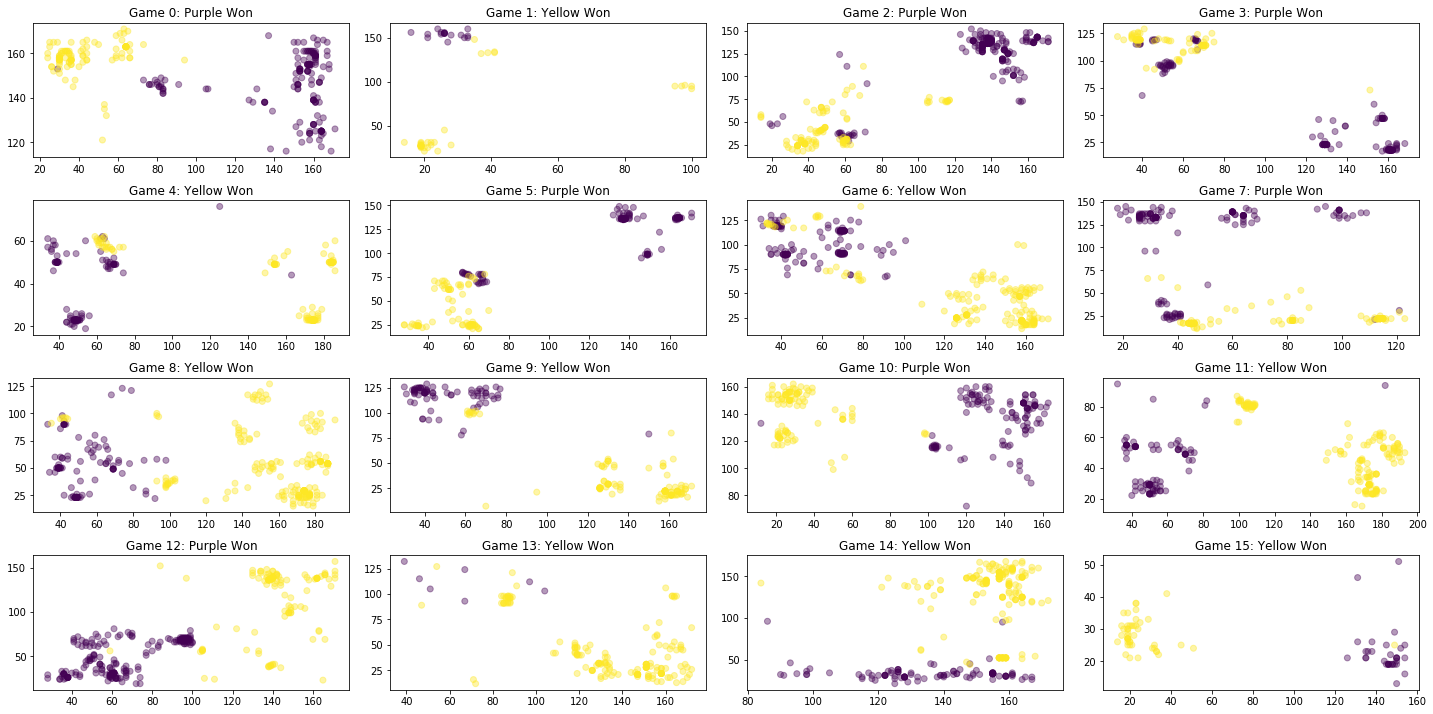

In [141]:
plot_game_end_states(iem_games)

Even without knowledge of the game or of the units represented it is sometimes possible to understand what is going on. It seems to us that in games 3,4,5,6 and 9 the winning player's army has formed a death ball that is overunning the oponent's base, and in games 2,6 and 8 the loosing player seems to be overwelmed by a two pronged attack from the winner.

We seek to encode the significance of this relative spatial arragement of units as a 1-d set of features in such a way that can be agregated across multiple games.

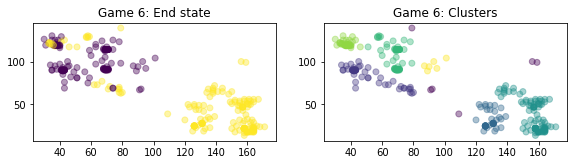

In [197]:
from sklearn.cluster import DBSCAN

# The terran marine has a range of 5.
# Tanks a range of between 7 and 13.
# Tempests have the longest range in the game at 15.

# We initialize a DBSCAN clusterer with parameters such that
# a unit will be considered part of an existing clustr if it sees 4 or more units 
# form that cluster within a 10 tile radius.

unit_clusterer = DBSCAN(eps=10,min_samples=5)

runits = get_end_location_of_units(preliminary_procecing(iem_games[6]))
predicted_clusters = unit_clusterer.fit_predict(runits[['x','y']])

plt.figure(figsize=(20,10))
plt.subplot(4,4,1)
plt.scatter(runits['x'], runits['y'], c=runits['owner'], alpha = 0.4)
plt.title('Game 6: End state')

plt.subplot(4,4,2)
plt.scatter(runits['x'], runits['y'], c=predicted_clusters, alpha = 0.4)
plt.title('Game 6: Clusters')

plt.show()

In [163]:
runits.to_csv('./../../../../Desktop/game_6_unit_data.csv')

In [193]:
unit_info_json = pd.read_json('/usr/local/lib/python3.6/site-packages/sc2reader/data/unit_info.json')\
.apply(lambda x:x['Protoss'] if x['Protoss'] == x['Protoss'] 
       else x['Terran'] if x['Terran'] == x['Terran'] else x['Zerg'], axis=1)

unit_lookup_table = pd.DataFrame([{**unit_info_json[key], **{'name':key}} 
                                  for key in unit_info_json.keys()]).fillna(False)

unit_lookup_table.head()

,is_army,is_building,is_worker,minerals,name,supply,vespene
0,True,False,False,175,archon,4.0,275
1,False,True,False,150,armory,0.0,100
2,False,True,False,75,assimilator,0.0,0
3,True,False,False,50,baneling,0.5,25
4,True,False,False,50,banelingburrowed,0.5,25


In [205]:
unit_details = pd.merge(runits, unit_lookup_table, how='left')
unit_details['predicted_cluster'] = predicted_clusters
unit_details.head()


,name,x,y,owner,is_army,is_building,is_worker,minerals,supply,vespene,predicted_cluster
0,drone,41,90,1,False,False,True,50,1.0,0,0
1,assimilator,132,42,2,False,True,False,75,0.0,0,1
2,fleetbeacon,152,18,2,False,True,False,300,0.0,200,2
3,creeptumorburrowed,101,104,1,False,True,False,0,0.0,0,5
4,hightemplar,160,51,2,True,False,False,50,2.0,150,2


In [206]:
unit_details.to_csv('./../../../../Desktop/game_6_unit_data.csv')

In [217]:
%%HTML
<script type='text/javascript' src='https://dub01.online.tableau.com/javascripts/api/viz_v1.js'>
</script><div class='tableauPlaceholder' style='width: 1004px; height: 836px;'>
<object class='tableauViz' width='1004' height='836' style='display:none;'>
<param name='host_url' value='https%3A%2F%2Fdub01.online.tableau.com%2F' />
<param name='site_root' value='&#47;t&#47;mkleinbortatgmailcom'/>
<param name='name' value='Sc2plots&#47;Dashboard1' /><param name='tabs'value='no'/>
<param name='toolbar' value='yes'/><param name='showAppBanner' value='false' />
<param name='showShareOptions' value='true' /></object></div>
